In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, mean_squared_error
from imblearn.combine import SMOTEENN

In [1]:

medical_selected_columns = [
    'VDRL_RESULT', 'PLAN_PREGNANCY',
    'HAS_PREG_RISK', 'MARITAL_STATUS',
    'FOOD_INSECURITY', 'NUM_ABORTIONS', 'NUM_LIV_CHILDREN', 'NUM_PREGNANCIES',
    'FAM_PLANNING', 'FAM_INCOME', 'AGE'
]
medical_categorical_columns = [
    'PLAN_PREGNANCY',
    'HAS_PREG_RISK', 'MARITAL_STATUS',
    'FOOD_INSECURITY', 'NUM_ABORTIONS', 'NUM_LIV_CHILDREN', 'NUM_PREGNANCIES',
    'FAM_PLANNING', 'FAM_INCOME'
]
medical_numerical_columns = ['NUM_ABORTIONS', 'NUM_LIV_CHILDREN', 'NUM_PREGNANCIES', 'FAM_INCOME', 'AGE']


In [4]:
df = pd.read_csv('data_set.csv')
df = df[medical_selected_columns]
df.head()

,VDRL_RESULT,PLAN_PREGNANCY,HAS_PREG_RISK,MARITAL_STATUS,FOOD_INSECURITY,NUM_ABORTIONS,NUM_LIV_CHILDREN,NUM_PREGNANCIES,FAM_PLANNING,FAM_INCOME,AGE
0,1.0,1.0,1.0,0.0,0.0,3.0,4.0,4.0,0.0,0.0,25.0
1,1.0,1.0,1.0,5.0,0.0,3.0,4.0,1.0,1.0,2.0,25.0
2,1.0,1.0,1.0,5.0,2.0,0.0,0.0,1.0,0.0,3.0,24.0
3,1.0,0.0,0.0,5.0,2.0,3.0,2.0,3.0,0.0,0.0,28.0
4,1.0,1.0,1.0,1.0,0.0,3.0,1.0,1.0,0.0,0.0,27.0


In [5]:
duplicates = df.duplicated()

num_duplicates = duplicates.sum()

print(f'Number of duplicate rows: {num_duplicates}')

df = df.drop_duplicates()

df.reset_index(drop=True, inplace=True)

Number of duplicate rows: 18208


In [6]:
max_value_counts = {}
for column in medical_categorical_columns:
    max_value = df[column].max()
    max_count = (df[column] == max_value).sum()
    max_value_counts[column] = max_count

print(f'Numero de não informados nas colunas:\n{max_value_counts}')


Numero de não informados nas colunas:
{'PLAN_PREGNANCY': 1652, 'HAS_PREG_RISK': 1656, 'MARITAL_STATUS': 9580, 'FOOD_INSECURITY': 9364, 'NUM_ABORTIONS': 10691, 'NUM_LIV_CHILDREN': 9400, 'NUM_PREGNANCIES': 3232, 'FAM_PLANNING': 5906, 'FAM_INCOME': 6063}


In [7]:
#metodo de preencher os nao informados pela moda (SO RODE SE QUISER PREENCHER, SE NAO PULE A CELULA)
for column in medical_categorical_columns:
    max_value = df[column].max()

    df[column] = df[column].replace(max_value, np.nan)
    mode_value = df[column].mode()[0]
    df[column].fillna(mode_value, inplace=True)

<ipython-input-7-aafc6dcd815c>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(mode_value, inplace=True)


In [7]:
for col in medical_categorical_columns:
  if col in df.columns:
    df[col] = df[col].astype('category')

df.dtypes


,0
VDRL_RESULT,float64
PLAN_PREGNANCY,category
HAS_PREG_RISK,category
MARITAL_STATUS,category
FOOD_INSECURITY,category
NUM_ABORTIONS,category
NUM_LIV_CHILDREN,category
NUM_PREGNANCIES,category
FAM_PLANNING,category
FAM_INCOME,category


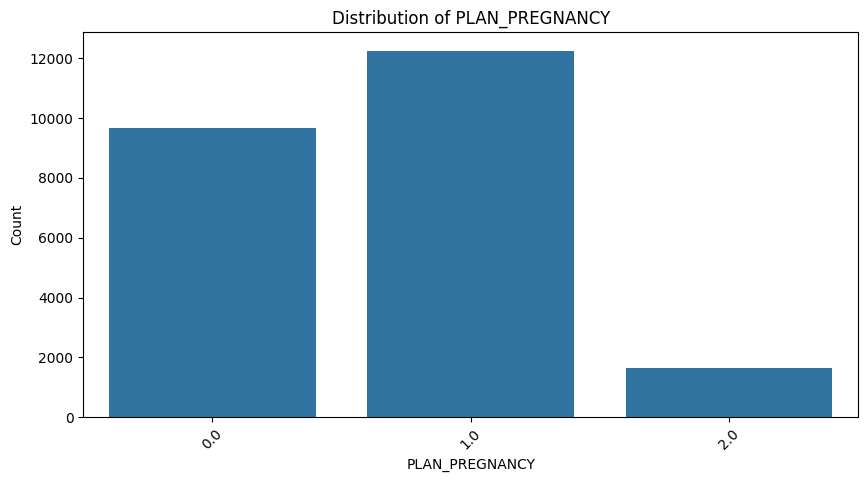

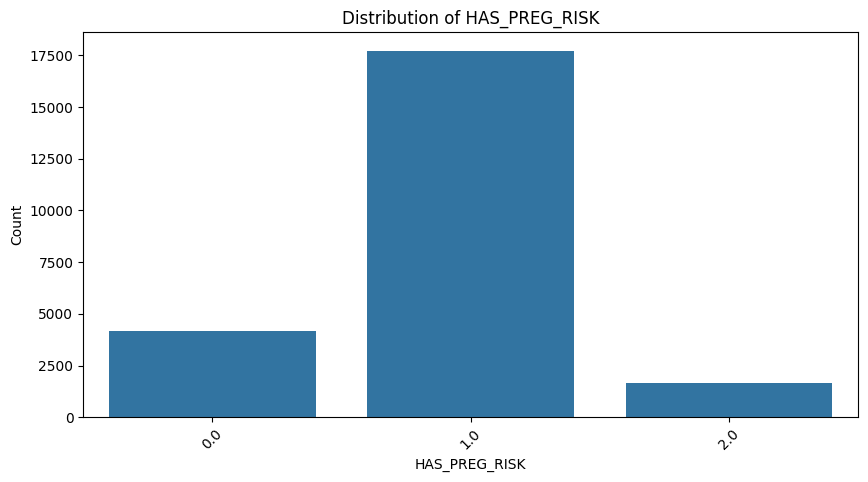

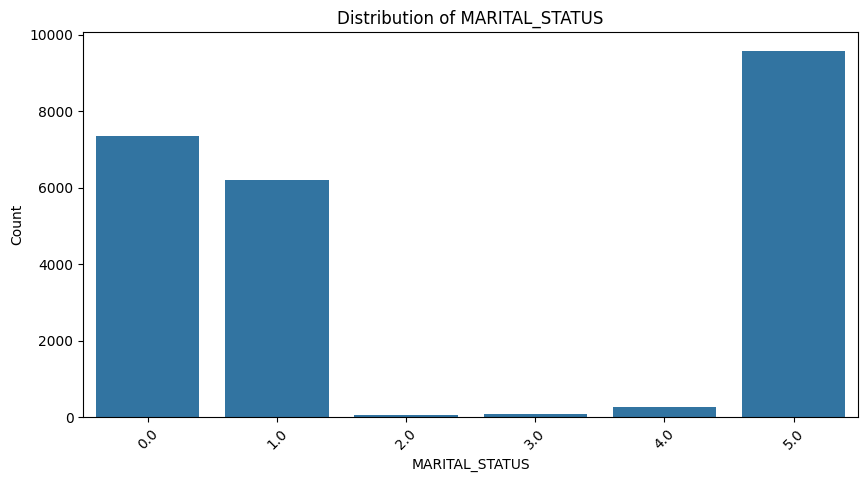

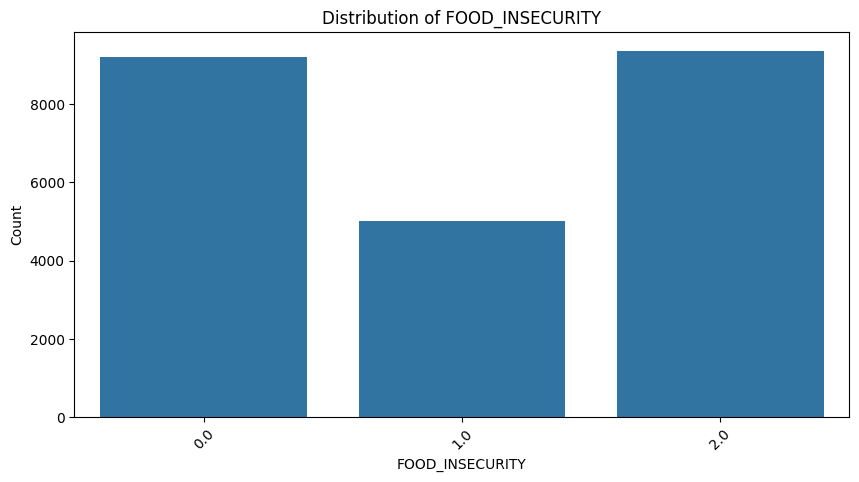

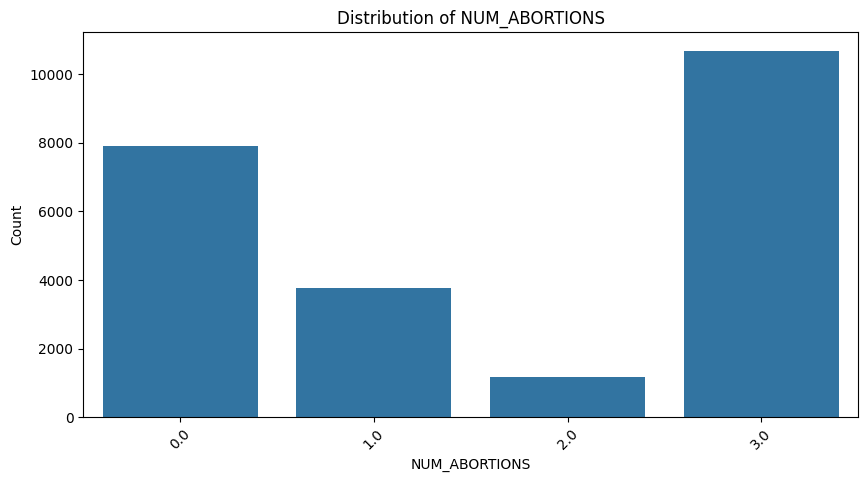

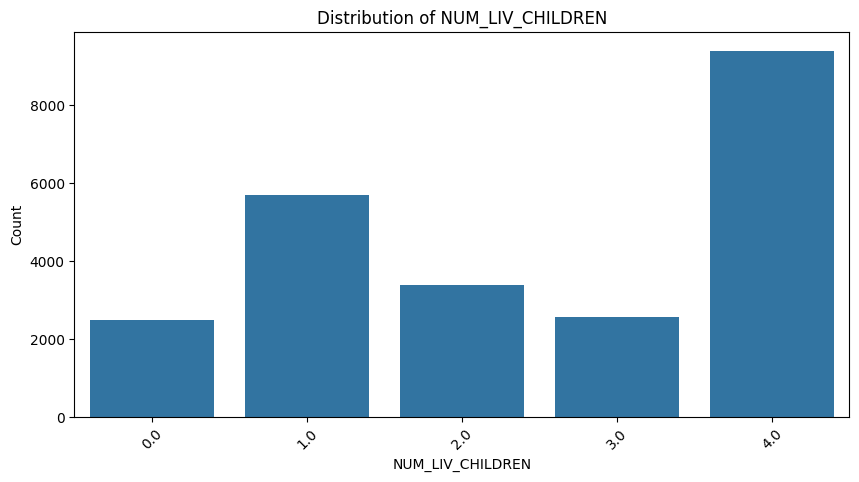

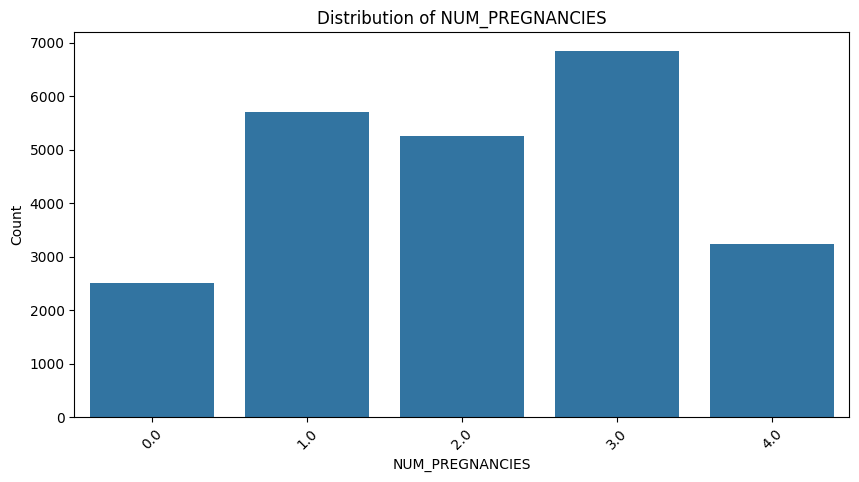

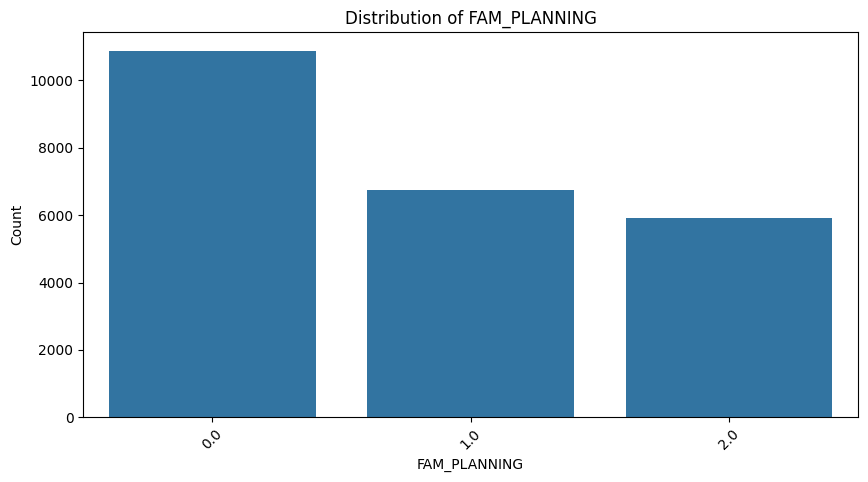

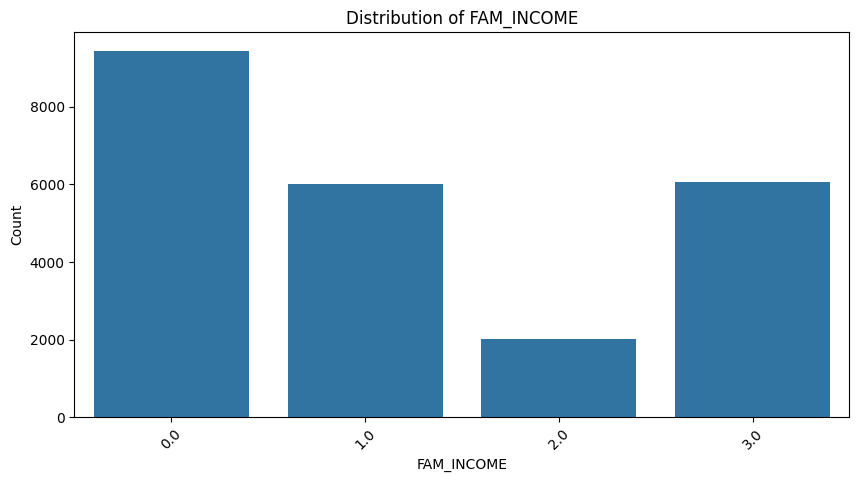

In [8]:
#PLOTAGEM PARA VER A DISTRIBUICAO DAS COLUNAS
for col in medical_categorical_columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=col, data=df)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

In [7]:
negative_ages = df[df['AGE'] < 0]
print(f"Number of negative ages: {negative_ages.shape[0]}")
df = df[(df['AGE'] >= 10) & (df['AGE'] <= 50)]

Number of negative ages: 1


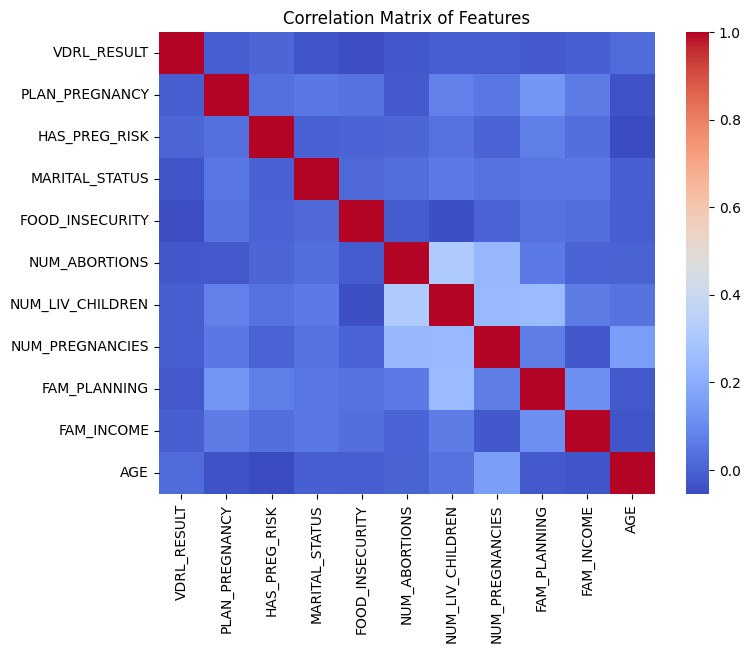

In [8]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()

In [16]:
df_encoded = pd.get_dummies(df, columns = medical_categorical_columns, drop_first = False)

In [21]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

X = df_encoded.drop(columns=['VDRL_RESULT'])
y = df['VDRL_RESULT']

undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

print("Distribuição original:", Counter(y))
print("Distribuição após under-sampling:", Counter(y_resampled))


Distribuição original: Counter({1.0: 22792, 0.0: 762})
Distribuição após under-sampling: Counter({0.0: 762, 1.0: 762})


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

In [23]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1066, 37), (458, 37), (1066,), (458,))

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold

dt_classifier = DecisionTreeClassifier(random_state=42)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search_dt = GridSearchCV(estimator=dt_classifier, param_grid=param_grid,
                           scoring='f1_macro', cv=kfold, n_jobs=-1)

grid_search_dt.fit(X_train, y_train)

print(f'Best F1-Score train: {grid_search_dt.best_score_}')
print(f'Best Hyperparameters: {grid_search_dt.best_params_}')


Best F1-Score train: 0.5878220657183475
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}


In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report, precision_score, recall_score

best_model_tree = DecisionTreeClassifier(
    criterion="gini",
    splitter="best",
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=None,
    random_state=42
)

best_model_tree.fit(X_train, y_train)

y_pred = best_model_tree.predict(X_test)

f1_tree = f1_score(y_test, y_pred, average='macro')
accuracy_tree = accuracy_score(y_test, y_pred)
precision_tree = precision_score(y_test, y_pred, average='macro')
recall_tree = recall_score(y_test, y_pred, average='macro')
report_tree = classification_report(y_test, y_pred)

print(f'F1-Score (Test): {f1_tree}')
print(f'Accuracy (Test): {accuracy_tree}')
print(f'Precision (Test): {precision_tree}')
print(f'Recall (Test): {recall_tree}')
print("Classification Report:\n", report_tree)


F1-Score (Test): 0.5608820709491851
Accuracy (Test): 0.5611353711790393
Precision (Test): 0.5671899224806202
Recall (Test): 0.5665233992747088
Classification Report:
               precision    recall  f1-score   support

         0.0       0.52      0.64      0.57       211
         1.0       0.61      0.50      0.55       247

    accuracy                           0.56       458
   macro avg       0.57      0.57      0.56       458
weighted avg       0.57      0.56      0.56       458



Top 10 Features por Importância:
                Feature  Importance
0                   AGE    0.198038
36       FAM_INCOME_3.0    0.044359
15  FOOD_INSECURITY_2.0    0.042931
8    MARITAL_STATUS_1.0    0.042522
28  NUM_PREGNANCIES_3.0    0.041735
1    PLAN_PREGNANCY_0.0    0.040121
34       FAM_INCOME_1.0    0.039122
19    NUM_ABORTIONS_3.0    0.038541
2    PLAN_PREGNANCY_1.0    0.038452
16    NUM_ABORTIONS_0.0    0.036089


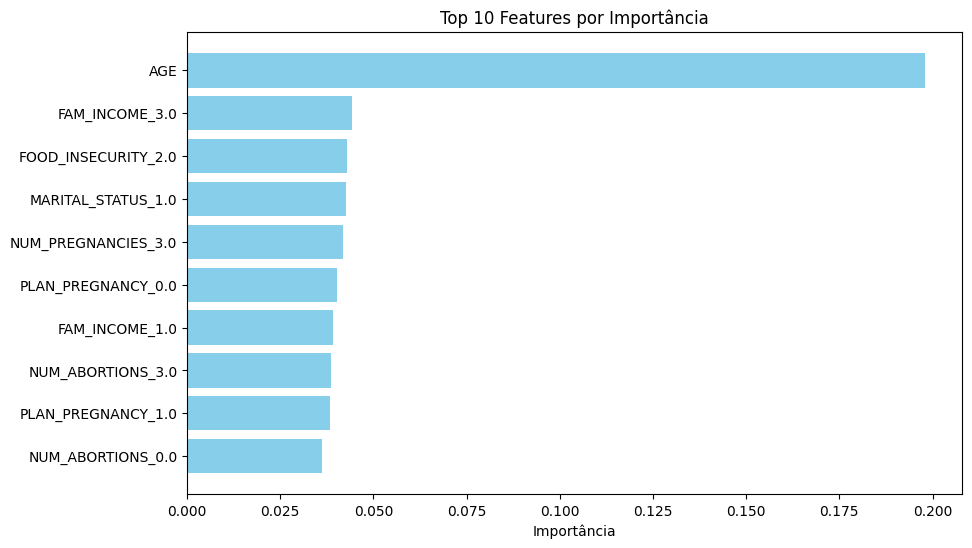

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

feature_names = X_train.columns

importances = best_model_tree.feature_importances_

feature_importances_tree = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Ordenar o DataFrame pelas importâncias de forma decrescente
feature_importances_tree = feature_importances_tree.sort_values(by='Importance', ascending=False)

# Selecionar as top 10 features
top_10_features_tree = feature_importances_tree.head(10)

# Exibir as top 10 features
print("Top 10 Features por Importância:")
print(top_10_features_tree)

# Opcional: Plotar as top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_10_features_tree['Feature'][::-1], top_10_features_tree['Importance'][::-1], color='skyblue')
plt.xlabel('Importância')
plt.title('Top 10 Features por Importância')
plt.show()


In [28]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}


grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           scoring='f1_macro', cv=5, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

print(f'Best F1-Score (XGBoost) train: {grid_search.best_score_}')
print(f'Best Hyperparameters: {grid_search.best_params_}')


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best F1-Score (XGBoost) train: 0.6085549352651631
Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:24:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [29]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

best_xgb_model = XGBClassifier(
    colsample_bytree=0.8,
    learning_rate=0.1,
    max_depth=7,
    n_estimators=50,
    subsample=0.8,
    random_state=42
)

best_xgb_model.fit(X_train, y_train)

y_pred = best_xgb_model.predict(X_test)

accuracy_xgb = accuracy_score(y_test, y_pred)
precision_xgb = precision_score(y_test, y_pred, average='macro')
recall_xgb = recall_score(y_test, y_pred, average='macro')
f1_xgb = f1_score(y_test, y_pred, average='macro')

print(f'Accuracy (Test): {accuracy_xgb}')
print(f'Precision (Test): {precision_xgb}')
print(f'Recall (Test): {recall_xgb}')
print(f'F1 Score (Test): {f1_xgb}')


Accuracy (Test): 0.6157205240174672
Precision (Test): 0.614487274948928
Recall (Test): 0.6150584262332828
F1 Score (Test): 0.6144781144781144



Top 10 Features por Importância (Gradient Boosting):
                 Feature  Importance
8     MARITAL_STATUS_1.0    0.055399
15   FOOD_INSECURITY_2.0    0.043083
18     NUM_ABORTIONS_2.0    0.037599
35        FAM_INCOME_2.0    0.036488
6      HAS_PREG_RISK_2.0    0.033269
20  NUM_LIV_CHILDREN_0.0    0.032097
0                    AGE    0.031572
28   NUM_PREGNANCIES_3.0    0.031413
3     PLAN_PREGNANCY_2.0    0.031374
19     NUM_ABORTIONS_3.0    0.031351


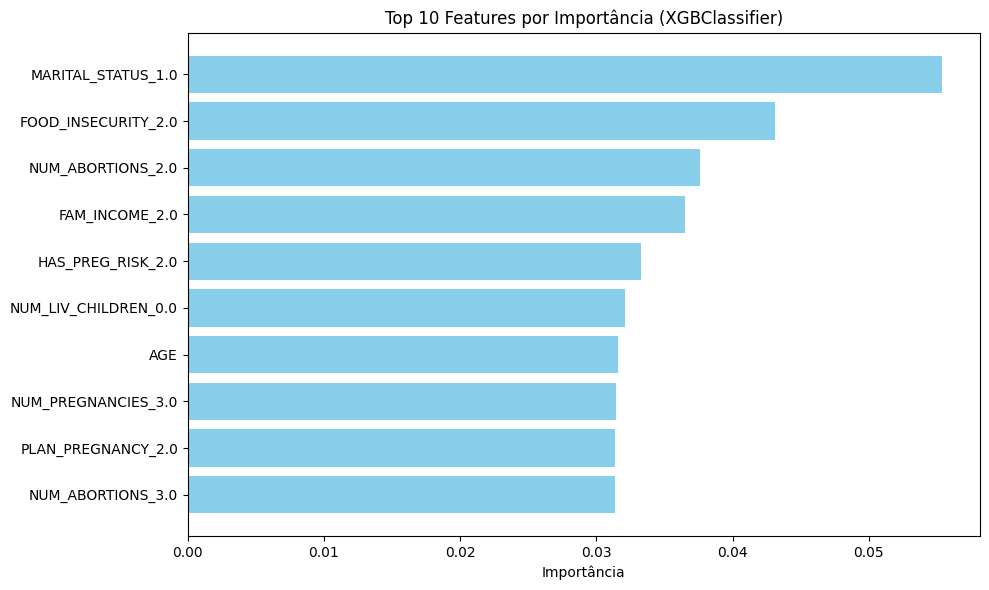

In [30]:
importances = best_xgb_model.feature_importances_

feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

top_10_features = feature_importances.head(10)

print("\nTop 10 Features por Importância (Gradient Boosting):")
print(top_10_features)

plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'][::-1], top_10_features['Importance'][::-1], color='skyblue')
plt.xlabel('Importância')
plt.title('Top 10 Features por Importância (XGBClassifier)')
plt.tight_layout()
plt.show()

In [31]:
from sklearn.ensemble import GradientBoostingClassifier

gb_classifier = GradientBoostingClassifier(random_state=42)

param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
}

grid_search_gb = GridSearchCV(estimator=gb_classifier, param_grid=param_grid_gb,
                             scoring='f1_macro', cv=5, n_jobs=-1, verbose=1)

grid_search_gb.fit(X_train, y_train)

print(f'Best F1-Score (Gradient Boosting) (Train): {grid_search_gb.best_score_}')
print(f'Best Hyperparameters (Gradient Boosting) (Train): {grid_search_gb.best_params_}')

best_gb_model = grid_search_gb.best_estimator_

y_pred_gb = best_gb_model.predict(X_test)

f1_gb = f1_score(y_test, y_pred_gb, average='macro')
accuracy_gb = accuracy_score(y_test, y_pred_gb)
precision_gb = precision_score(y_test, y_pred_gb, average='macro')
recall_gb = recall_score(y_test, y_pred_gb, average='macro')
report_gb = classification_report(y_test, y_pred_gb)

print(f'F1-Score (Test): {f1_gb}')
print(f'Accuracy (Test): {accuracy_gb}')
print(f'Precision (Test): {precision_gb}')
print(f'Recall (Test): {recall_gb}')

print("Classification Report (Gradient Boosting):\n", report_gb)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best F1-Score (Gradient Boosting) (Train): 0.6091263005890885
Best Hyperparameters (Gradient Boosting) (Train): {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1.0}
F1-Score (Test): 0.5823940804391932
Accuracy (Test): 0.5829694323144105
Precision (Test): 0.5831426392067125
Recall (Test): 0.5836579235182378
Classification Report (Gradient Boosting):
               precision    recall  f1-score   support

         0.0       0.54      0.59      0.57       211
         1.0       0.62      0.57      0.60       247

    accuracy                           0.58       458
   macro avg       0.58      0.58      0.58       458
weighted avg       0.59      0.58      0.58       458




Top 10 Features por Importância (Gradient Boosting):
                 Feature  Importance
0                    AGE    0.241929
8     MARITAL_STATUS_1.0    0.056549
15   FOOD_INSECURITY_2.0    0.054767
19     NUM_ABORTIONS_3.0    0.045976
30      FAM_PLANNING_0.0    0.030173
2     PLAN_PREGNANCY_1.0    0.028953
3     PLAN_PREGNANCY_2.0    0.026399
18     NUM_ABORTIONS_2.0    0.025404
24  NUM_LIV_CHILDREN_4.0    0.024893
6      HAS_PREG_RISK_2.0    0.024733


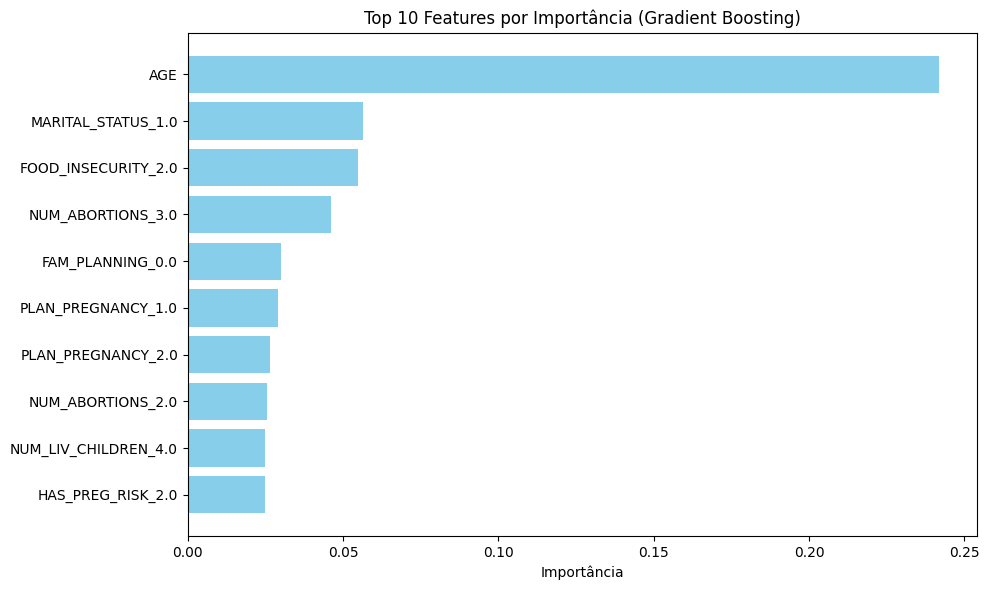

In [32]:
importances = best_gb_model.feature_importances_

feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

top_10_features = feature_importances.head(10)

print("\nTop 10 Features por Importância (Gradient Boosting):")
print(top_10_features)

plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'][::-1], top_10_features['Importance'][::-1], color='skyblue')
plt.xlabel('Importância')
plt.title('Top 10 Features por Importância (Gradient Boosting)')
plt.tight_layout()
plt.show()

In [33]:

model_data_result = {
    'Métricas': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Decision Tree': [accuracy_tree, precision_tree, recall_tree, f1_tree],
    'XGBoost': [accuracy_xgb, precision_xgb, recall_xgb, f1_xgb],
    'Gradient Boosting': [accuracy_gb, precision_gb, recall_gb, f1_gb]
}

metrics_df = pd.DataFrame(model_data_result)


In [34]:
# Derreter o DataFrame para o formato longo
metrics_melted = metrics_df.melt(id_vars='Métricas', var_name='Modelo', value_name='Valor')
print(metrics_melted)


     Métricas             Modelo     Valor
0    Accuracy      Decision Tree  0.561135
1   Precision      Decision Tree  0.567190
2      Recall      Decision Tree  0.566523
3    F1 Score      Decision Tree  0.560882
4    Accuracy            XGBoost  0.615721
5   Precision            XGBoost  0.614487
6      Recall            XGBoost  0.615058
7    F1 Score            XGBoost  0.614478
8    Accuracy  Gradient Boosting  0.582969
9   Precision  Gradient Boosting  0.583143
10     Recall  Gradient Boosting  0.583658
11   F1 Score  Gradient Boosting  0.582394


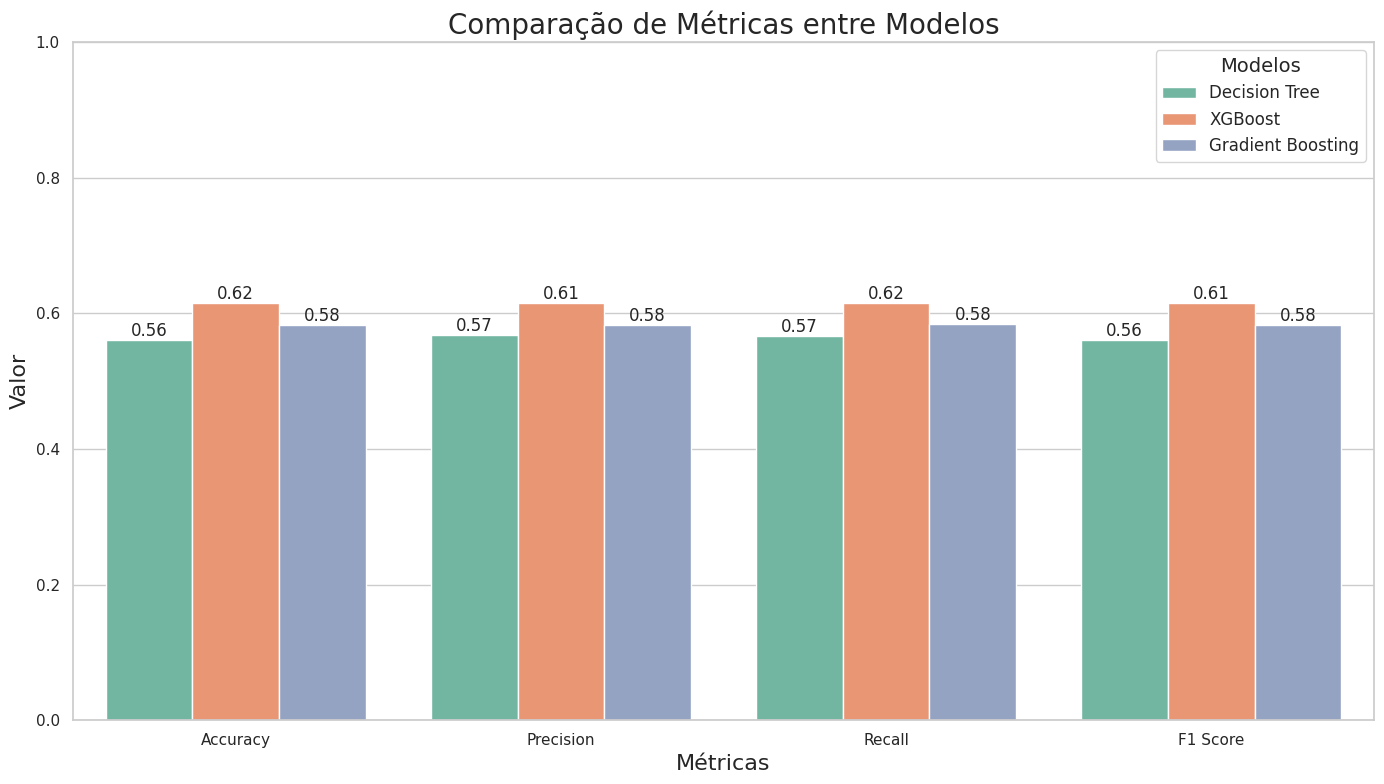

In [35]:
sns.set(style="whitegrid")

# Definir o tamanho da figura
plt.figure(figsize=(14, 8))

# Criar o gráfico de barras agrupadas
sns.barplot(x='Métricas', y='Valor', hue='Modelo', data=metrics_melted, palette='Set2')

# Adicionar títulos e rótulos
plt.title('Comparação de Métricas entre Modelos', fontsize=20)
plt.xlabel('Métricas', fontsize=16)
plt.ylabel('Valor', fontsize=16)

# Adicionar anotações de valores nas barras
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.2f', fontsize=12)

# Ajustar a legenda
plt.legend(title='Modelos', fontsize=12, title_fontsize=14)

# Opcional: Rotacionar os rótulos do eixo X
# plt.xticks(rotation=45)

# Opcional: Definir limites ao eixo Y
plt.ylim(0, 1)

# Mostrar o gráfico
plt.tight_layout()
plt.show()


# Regressão para a variavel `AGE`

In [50]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [51]:
columns_to_drop = ["RH_FACTOR", "BLOOD_GROUP", "HAS_FRU_TREE", "HAS_VEG_GARDEN", "WATER_TREATMENT", "CONN_SEWER_NET", "FOOD_INSECURITY"]

categorical_columns = [
    'VDRL_RESULT',
    'SMOKER',
    'CONS_ALCOHOL',
    'NUM_ABORTIONS'
    'PLAN_PREGNANCY',
    'HAS_PREG_RISK', 'TET_VACCINE', 'IS_HEAD_FAMILY', 'MARITAL_STATUS',
    'FAM_PLANNING', 'TYPE_HOUSE', 'HAS_FAM_INCOME', 'LEVEL_SCHOOLING', 'HOUSING_STATUS'
]

In [60]:
df_age = pd.read_csv('data_set.csv')


In [61]:
duplicates = df_age.duplicated()

num_duplicates = duplicates.sum()

print(f'Number of duplicate rows: {num_duplicates}')

df_age = df_age.drop_duplicates()

df_age.reset_index(drop=True, inplace=True)

Number of duplicate rows: 833


In [62]:
negative_ages = df_age[df_age['AGE'] < 0]
print(f"Number of negative ages: {negative_ages.shape[0]}")
df_age = df_age[df_age['AGE'] > 0]

Number of negative ages: 1


In [63]:
df_age = df_age.drop(columns=columns_to_drop)
for col in categorical_columns:
  if col in df_age.columns:
    df_age[col] = df_age[col].astype('category')

df_age.dtypes

,0
VDRL_RESULT,category
CONS_ALCOHOL,category
SMOKER,category
PLAN_PREGNANCY,float64
HAS_PREG_RISK,category
TET_VACCINE,category
IS_HEAD_FAMILY,category
MARITAL_STATUS,category
NUM_ABORTIONS,float64
NUM_LIV_CHILDREN,float64


In [64]:
X = df_age.drop(columns=['AGE'])
y = df_age['AGE']

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [66]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [67]:
linear_model = LinearRegression()

# Treinamento do modelo
linear_model.fit(X_train, y_train)

# Predições no conjunto de teste
y_pred_linear = linear_model.predict(X_test)

# Avaliação
mse_linear = mean_squared_error(y_test, y_pred_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
mape_linear = mean_absolute_percentage_error(y_test, y_pred_linear)

print(f'Mean Squared Error (Linear Regression): {mse_linear}')
print(f'Mean Absolute Error (Linear Regression): {mae_linear}')
print(f'Mean Absolute Percentage Error (Linear Regression): {mape_linear}')



Mean Squared Error (Linear Regression): 19.858844586802526
Mean Absolute Error (Linear Regression): 2.9007144975074204
Mean Absolute Percentage Error (Linear Regression): 0.12094931495866172


In [68]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV


# Gradient Boosting Regressor com ajuste de hiperparâmetros
gbr = GradientBoostingRegressor(random_state=42)
param_dist_gbr = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}
rand_search_gbr = RandomizedSearchCV(gbr, param_dist_gbr, cv=3, scoring='neg_mean_squared_error', n_iter=5, random_state=42)
rand_search_gbr.fit(X_train, y_train)

best_gbr_model = rand_search_gbr.best_estimator_
y_pred_gbr = best_gbr_model.predict(X_test)

# Avaliação
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
mape_gbr = mean_absolute_percentage_error(y_test, y_pred_gbr)

print(f'Mean Squared Error (Gradient Boosting): {mse_gbr}')
print(f'Mean Absolute Error (Gradient Boosting): {mae_gbr}')
print(f'Mean Absolute Percentage Error (Gradient Boosting): {mape_gbr}')


Mean Squared Error (Gradient Boosting): 16.986897603813134
Mean Absolute Error (Gradient Boosting): 2.894116694380836
Mean Absolute Percentage Error (Gradient Boosting): 0.12001389392316708


In [70]:

# Feature Importance for best_gbr_model
feature_importances = best_gbr_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top 10 most important features
print("Top 10 Feature Importance:")
print(feature_importance_df.head(10))

Top 10 Feature Importance:
              Feature  Importance
10    NUM_PREGNANCIES    0.229787
14    LEVEL_SCHOOLING    0.221630
9    NUM_LIV_CHILDREN    0.125546
7      MARITAL_STATUS    0.099772
15  NUM_RES_HOUSEHOLD    0.049942
6      IS_HEAD_FAMILY    0.035110
4       HAS_PREG_RISK    0.028484
3      PLAN_PREGNANCY    0.027376
8       NUM_ABORTIONS    0.024593
16         FAM_INCOME    0.024490


In [71]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Random Forest Regressor com ajuste de hiperparâmetros
rfr = RandomForestRegressor(random_state=42)
param_dist_rfr = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rand_search_rfr = RandomizedSearchCV(
    estimator=rfr,
    param_distributions=param_dist_rfr,
    cv=3,
    scoring='neg_mean_squared_error',
    n_iter=5,
    random_state=42
)

rand_search_rfr.fit(X_train, y_train)

best_rfr_model = rand_search_rfr.best_estimator_
y_pred_rfr = best_rfr_model.predict(X_test)

# Avaliação
mse_rfr = mean_squared_error(y_test, y_pred_rfr)
mae_rfr = mean_absolute_error(y_test, y_pred_rfr)
mape_rfr = mean_absolute_percentage_error(y_test, y_pred_rfr)

print(f'Mean Squared Error (Random Forest): {mse_rfr}')
print(f'Mean Absolute Error (Random Forest): {mae_rfr}')
print(f'Mean Absolute Percentage Error (Random Forest): {mape_rfr}')


Mean Squared Error (Random Forest): 17.472113963056092
Mean Absolute Error (Random Forest): 2.87672204643101
Mean Absolute Percentage Error (Random Forest): 0.11951422142608673


In [72]:

# Feature Importance for best_gbr_model
feature_importances_rfr = best_rfr_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_rfr = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances_rfr})

# Sort the DataFrame by importance in descending order
feature_importance_rfr = feature_importance_rfr.sort_values(by='Importance', ascending=False)

# Display the top 10 most important features
print("Top 10 Feature Importance:")
print(feature_importance_rfr.head(10))

Top 10 Feature Importance:
              Feature  Importance
10    NUM_PREGNANCIES    0.305852
14    LEVEL_SCHOOLING    0.229194
9    NUM_LIV_CHILDREN    0.144323
7      MARITAL_STATUS    0.085581
15  NUM_RES_HOUSEHOLD    0.037525
4       HAS_PREG_RISK    0.028237
6      IS_HEAD_FAMILY    0.023515
11       FAM_PLANNING    0.021871
17     HOUSING_STATUS    0.019614
12         TYPE_HOUSE    0.017736


In [84]:

linear_model_data_result = {
    'Métricas': ['MSE', 'MAE', 'MAPE'],
    'Linear Regression': [mse_linear, mae_linear, mape_linear],
    'Gradient Boosting Regressor': [mse_gbr, mae_gbr, mape_gbr],
    'Random Forest Regressor': [mse_rfr, mae_rfr, mape_rfr]
}

metrics_linear_df = pd.DataFrame(linear_model_data_result)
linear_metrics_melted = metrics_linear_df.melt(id_vars='Métricas', var_name='Modelo', value_name='Valor')


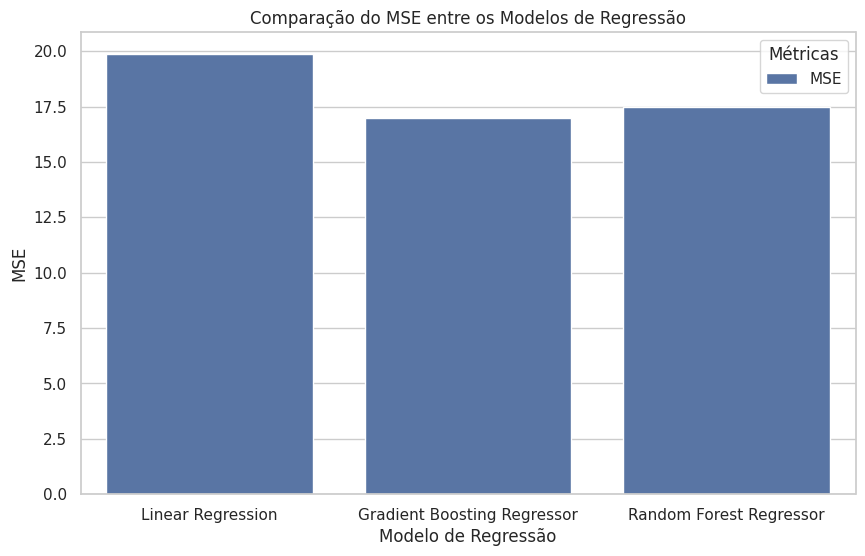

In [85]:
# prompt: plot a graph to compare mse from the 3 regression models

import matplotlib.pyplot as plt
import seaborn as sns

# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Modelo', y='Valor', hue='Métricas', data=linear_metrics_melted[linear_metrics_melted['Métricas'] == 'MSE'])
plt.title('Comparação do MSE entre os Modelos de Regressão')
plt.xlabel('Modelo de Regressão')
plt.ylabel('MSE')
plt.show()

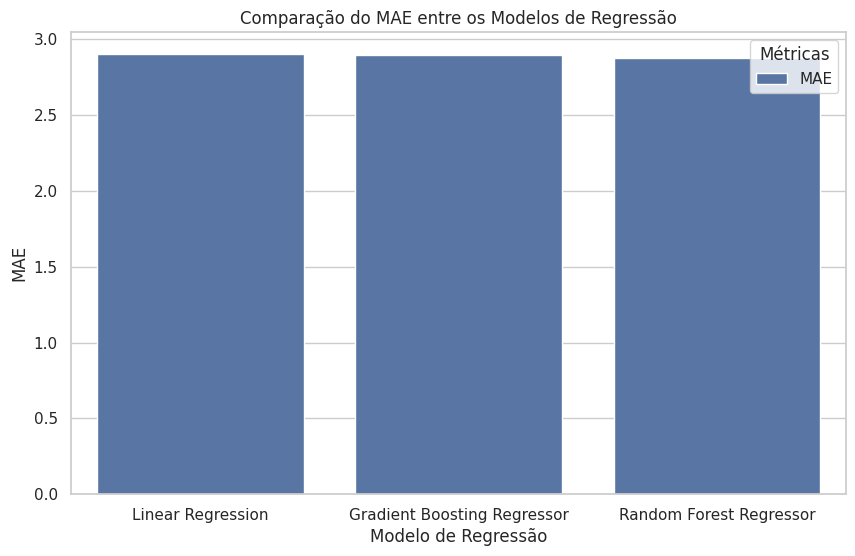

In [87]:
# prompt: now plot a graph for comparing MAE

import matplotlib.pyplot as plt
import seaborn as sns

linear_model_data_result = {
    'Métricas': ['MSE', 'MAE', 'MAPE'],
    'Linear Regression': [mse_linear, mae_linear, mape_linear],
    'Gradient Boosting Regressor': [mse_gbr, mae_gbr, mape_gbr],
    'Random Forest Regressor': [mse_rfr, mae_rfr, mape_rfr]
}

metrics_linear_df = pd.DataFrame(linear_model_data_result)
linear_metrics_melted = metrics_linear_df.melt(id_vars='Métricas', var_name='Modelo', value_name='Valor')

# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Modelo', y='Valor', hue='Métricas', data=linear_metrics_melted[linear_metrics_melted['Métricas'] == 'MAE'])
plt.title('Comparação do MAE entre os Modelos de Regressão')
plt.xlabel('Modelo de Regressão')
plt.ylabel('MAE')
plt.show()

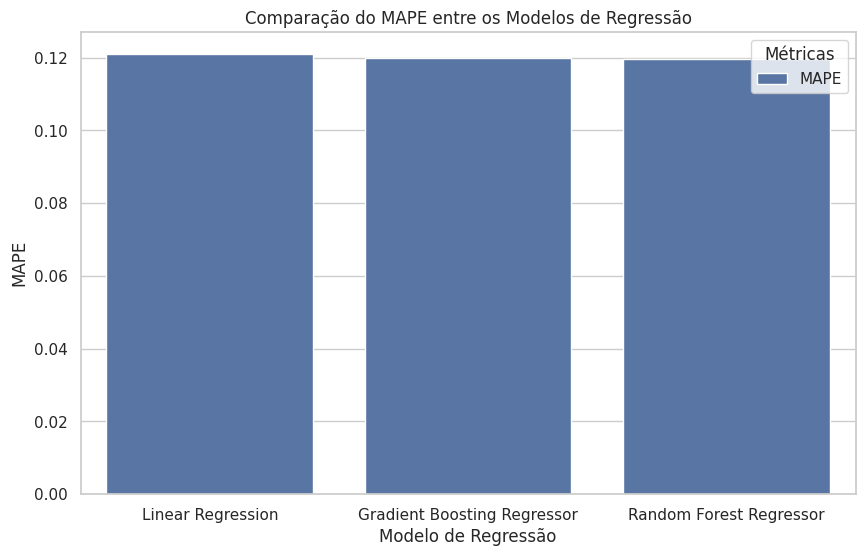

In [88]:
# prompt: now plot a graph to compare MAPE

# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Modelo', y='Valor', hue='Métricas', data=linear_metrics_melted[linear_metrics_melted['Métricas'] == 'MAPE'])
plt.title('Comparação do MAPE entre os Modelos de Regressão')
plt.xlabel('Modelo de Regressão')
plt.ylabel('MAPE')
plt.show()